## Outline

<a name="outline"></a>

- [Section 1](#section-1): K-means Clustering
- [Section 2](#section-2): Hierarchical Clustering

## Introduction

The purpose of this notebook is to understand and implement two popular unsupervised learning methods to cluster data points.

In [2]:
# imports
import numpy as np
import numpy.testing as npt # for testing.
import logging # debugging.
from tqdm.notebook import tqdm # progress

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Initial global configuration for matplotlib
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

We generate data with the `make_blobs` function. Although clustering methods are commonly used in unsupervised learning settings where no label *y* (cluster assignments) is available, we generate synthetic data with ground truth clusters for comparison later.

The number of dimensions can be specified by `n_features` in the function below. To simplify our setting, we will only consider data points in 3-dimensional space but these methods can also be used in higher dimensions and you are encouraged to try out these scenarios.

In [3]:
# generate data
X, cluster_assignment = make_blobs(n_samples=400, n_features=3, centers=5,
                                   cluster_std=1.2,
                                   random_state=5, center_box=(0, 20))

`cluster_assignment` is the ground-truth that represents the true membership of each point to one of the three clusters. In practice we do not have it and we aim to **discover** these assignments without having any access to a train-split with given labels (as we do in supervised learning).

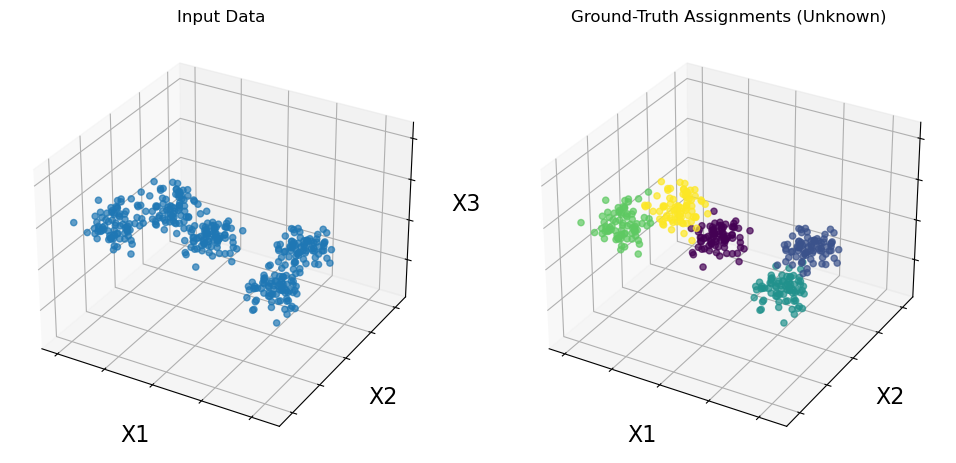

In [4]:
# Visualize the 3D data
fig = plt.figure(figsize=(12, 8))
ax1, ax2 = fig.add_subplot(121, projection='3d'), fig.add_subplot(122, projection='3d')

ax1.scatter(X[:, 0], X[:, 1], X[:, 2],  alpha=0.7)
ax1.set_title('Input Data')
ax1.set_xticklabels([]); ax1.set_yticklabels([]); ax1.set_zticklabels([]);
ax1.set_xlabel('X1'); ax1.set_ylabel('X2'); ax1.set_zlabel('X3')

ax2.scatter(X[:, 0], X[:, 1], X[:, 2], alpha=0.7,
           # We use cluster_assignment only to visualize the ground-truth
           # (the ideal clustering) in practice we don't have it and aim to estimate y.
           c=cluster_assignment)
ax2.set_title('Ground-Truth Assignments (Unknown)')
ax2.set_xticklabels([]); ax2.set_yticklabels([]); ax2.set_zticklabels([]);
ax2.set_xlabel('X1'); ax2.set_ylabel('X2'); ax2.set_zlabel('X3');

# Show the plot
plt.show()

<a name="section-1"></a>

# Section 1: $k$-means Clustering ([index](#outline))

$k$-means is a simple clustering algorithm that follows the following steps:

1. Given a number of clusters $k$, assign every sample to one of the $k$-clusters at random.
2. Compute the centroid of each of the $k$- clusters:
$$\boldsymbol{m}_l = \frac{1}{|c_l|} \sum_{i \in c_l} \boldsymbol{x}_i, \quad l=1, \ldots, k$$
3. Reassign each $\boldsymbol{x}_i$ to the closest centroid.
4. Repeat step (2) and (3) until:
    - Assignments/labels do not change, or
    - the within-distance $W(C)$ converges, wich is defined as:
    $$\frac{1}{2} \sum_{l=1}^k \frac{1}{|c_l|}\sum_{i, j \in c_l}||\boldsymbol{x}^{(i)} - \boldsymbol{x}^{(j)}||^2$$
    - or, **optionally**, the number of iterations exceeds a predefined number `max_iters`.


By applying this algorithm to the dataset generated above, we expect the following clustering trajectory:

![kmeans](https://raw.githubusercontent.com/barahona-research-group/mfds-resources/main/images/kmeans_k5.gif)

To implement the 4-step k-means algorithm we develop some useful subroutines:

- `compute_centroids`: from samples and their assignments, return the corresponding centroids (for step 2).
- `compute_within_distance`: from centroids, samples, and their assignments, compute the within-distance (used for step 4 convergence check).
- `kmeans_assignments`: from centroids and samples, return the new assignments (for step 3)

In `kmeans_assignments` and `compute_within_distance` functions, we need to consider an edge case. It is possible that the new cluster assignments miss out one of centroids, which means that we now have an empty cluster, or equivalently, we have two clusters accidentally collided to one cluster. The computed centroids in the next iteration will be `NaN`, which is a special numerical value to encode missingness, or a problematic result. We need to handle the `NaN` centroid carefully in `kmeans_assignments` and `compute_within_distance`.


Now we implement `compute_within_distance`. An equivalent formulation of $W(C)$ (page 103 in the notes), can be written as:

$$
W(C) = \sum_{l=1}^k \sum_{i \in c_l} ||\boldsymbol{x}^{(i)} - \boldsymbol{m}_l||^2
$$

where $\boldsymbol{m}_l$ denotes the $l$-th cluster centroid.


In [5]:
def compute_within_distance(centroids, X, labels):
    """
    Compute the within-cluster distance.

    Args:
        centroids (np.ndarray): the centroids array, with shape (k, p).
        X (np.ndarray): the samples array, with shape (N, p).
        labels (np.ndarray): the cluster index of each sample, with shape (N,).

    Retruns:
        (float): the within-cluster distance.
    """
    within_distance = 0.0
    k, p = centroids.shape

    for l in range(len(centroids)):
        centroid = centroids[l]
        # Applying aggregate computations on `NaN` values
        # can propagate the `NaN` to the results.
        # In this case we skip the `NaN` centroid,
        # which is effectively of an empty cluster.
        if np.isnan(centroid).any():
            continue

        # Select samples belonging to label=l.
        X_cluster = X[labels == l]

        # You need to add the `X_cluster` contribution to `within_distance`

        # 1. Compute the cluster contribution.
        cluster_se = (X_cluster - centroid)**2
        assert cluster_se.shape == (len(X_cluster), p) 
        # 2. Accumulate
        within_distance += np.sum(cluster_se)

    return within_distance


Now implement `compute_centroids` that we use in step 2.

In [6]:
def compute_centroids(k, X, labels):
    """
    Compute the centroids of the clustered points X.

    Args:
        k (int): total number of clusters.
        X (np.ndarray): data points, with shape (N, p)
        labels (np.ndarray): cluster assignments for each sample in X, with shape (N,).

    Returns:
        (np.ndarray): the centroids of the k clusters, with shape (k, p).
    """
    N, p = X.shape

    centroids = np.zeros((k, p))

    for label in range(k):
        cluster_X_l = X[labels == label]
        centroids[label] = cluster_X_l.mean(axis=0) 

    return centroids


Make sure the following simple test case runs successfully.

In [7]:
# Test case.
X_test = np.array([[1, 1, 0],
                    [2, 2, 1],
                    [5, 3, 4],
                    [8, 3, 2]])
labels = np.array([0, 0, 1, 1])

centroids = np.array([[1.5, 1.5, 0.5],
                      [6.5, 3, 3]])

# Test compute_centroids
npt.assert_allclose(compute_centroids(2, X_test, labels),  centroids)


# Test compute_within_distance.
npt.assert_allclose(compute_within_distance(centroids, X_test, labels), 8.0)

Now, to the subroutine `kmeans_assignments`.

In [8]:
def kmeans_assignments(centroids, X):
    """
    Assign every example to the index of the closest centroid.

    Args:
        centroids (np.ndarray): The centroids of the k clusters, shape: (k, p).
        X (np.ndarray): The samples array, shape (N, p).

    Returns:
        (np.ndarray): an assignment matrix to k clusters, by their indices.
    """
    k, p = centroids.shape
    N, _ = X.shape

    # Compute distances between data points and centroids. Assumed shape: (k, N).
    distances = np.vstack([np.linalg.norm(X - c, axis=1) for c in centroids]) 
    # Note: If any centroid has NaN, the NaN value will propagate into the
    # distance corresponding row, we need to skip that row next when we search
    # for the closest centroid.

    assert distances.shape == (k, N), f"Unexpected shape {distances.shape} != {(k, N)}"
    # Assignments are computed by finding the centroid with the minimum distance
    # for each sample. The np.nanargmin returns the index of the minimum values
    # in `distances` scanning the rows (axis=0) for each column,
    # while skipping any nan value found.
    return np.nanargmin(distances, axis=0)



Some test cases to pass.

In [9]:
# Test case.
X_test = np.array([[1, 1, 0],
                    [2, 2, 1],
                    [5, 3, 4],
                    [8, 3, 2],
                    [11,4, -1]])

labels = np.array([0, 0, 1, 1, 1])

centroids = np.array([[1.5, 1.5, 0.5],
                      [6.5, 3, 3]])

# Test kmeans_assignments
npt.assert_equal(kmeans_assignments(centroids, X_test),  labels)


We are ready to implement `kmeans_clustering` that builds on the previous subroutines.


In [10]:
def kmeans_clustering(X, k,
                      max_iters=1000,
                      epsilon=0.0,
                      callback=None):
    """
    Apply k-means clustering algorithm on the samples in `X` to generate
    k clusters.

    Notes:
      The main steps followed here are described previously:
        1. randomly assignments of the points to $k$-clusters.
        2. compute the centroid of each of the $k$- clusters.
        3. reassign each point to the closest centroid.
        4. repeat steps (2) and (3) until:
            - assignments/labels do not change, or
            - the within-distance $W(C)$ converges with `epsilon` tolerence.
            - or the number of iterations exceeds `max_iters`.


    Args:
        X (np.ndarray): The samples array, shape: (N, p).
        k (int): The number of clusters.
        max_iters (int): Maximum number of iterations.
        epsilon (float): The minimum change in the within-distance to continue.
        callback (Callable): a function to be called on the assignments,
            the centroids, and within-distance after each iteration, default is None.

    Returns:
        Tuple[np.ndarray, np.ndarray]: the assignments array to k clusters with
            shape (N,) and the centroids array
    """
    # Step 1: randomly initialise the cluster assignments.
    labels = np.random.choice(k, size=len(X), replace=True) 

    within_distance = np.inf

    for _ in range(max_iters):
        # Step 2: compute the centroids
        centroids = compute_centroids(k, X, labels)

        if callback:
            callback(labels, centroids)

        # Step 3: reassignments.
        new_labels = kmeans_assignments(centroids, X) 

        _within_distance = compute_within_distance(centroids, X, labels)

        # Step 4: repeat (2) and (3) until a termination condition.
        if all(labels == new_labels) or abs(_within_distance - within_distance) < epsilon: 
            break

        labels = new_labels
        within_distance = _within_distance


    return labels, centroids, within_distance


We are now ready to apply $k$-means clustering to our synthetic data. While choosing the right $k$ is difficult in real world applications and there a many different heuristics (see lecture notes), we simply choose $k=5$ for demonstration purposes as we have 5 ground-truth clusters.

In [11]:
max_iters = 100
epsilon = 0
k = 5

intermediates = []
# Our callback stores all the intermediate labels and centroids
# in case we need them for debugging and visualisations.
callback = lambda labels, centroids: intermediates.append((labels, centroids))

labels, centroids, wd = kmeans_clustering(X, k=k, max_iters=max_iters,
                                        epsilon=epsilon,
                                        callback=callback)


/var/folders/jp/grqnzlgx0rs6fmc9653rbr180000gn/T/ipykernel_56554/3980258544.py:21: RuntimeWarning: Mean of empty slice.
  centroids[label] = cluster_X_l.mean(axis=0)
/Users/adamboustani/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [12]:
# `intermediates` list is now populated with the clustering trajectory.
len(intermediates)

3

Now we often observe by executing the cell above several times the following warning message `RuntimeWarning: Mean of empty slice.`. This message means that one of the centroids is not selected by any point, so the next iteration we compute the centroids, one of them is computed by applying `np.mean(X_cluster, axis=0)`, while `X_cluster` is an empty array, which results in a vector of `NaN` values as the new centroid.

One way to address this problem, without changing the functions above, is to apply the `kmeans_clustering` multiple times since different initialisation results in different intermediate clustering, from which we may obtain a clustering trajectory without the empty cluster issue. This also gives us an opportunity to select the best clustering among different initialisations using the *within-cluster* distance as a selection metric. As we will see, clustering with fewer $k$ clusters have in general higher *within-cluster* distance, so choosing the clustering with minimum *within-cluster* distance will result in the clustering with the highest separation quality as well as excluding clustering with empty clusters (that are effectively with a number of clusters $k' < k$).

In [13]:
def kmeans_clustering_multi_runs(X, k, max_iters=100,
                                 epsilon=0.0,
                                 n_runs=100, seed=0):
    """
    Perform multiple runs (with different initialisations) of kmeans algorithm
    and return the best clustering using the within-cluster distance.

    Args:
        X (np.ndarray): The samples array, shape (N, p).
        k (int): The number of clusters.
        max_iters (int): Maximum iterations of kmeans algorithm.
        epsilon (float): The convergence threshold of kmeans algorithm.
        n_runs (int): The number of runs of kmeans with different initialisations.
        seed (int): A seed value before starting the n_runs loop.

    Returns:
        Tuple[np.ndarray, ...]: A tuple that encapsulates (labels, centroids,
        intermediate clustering, within-cluster distance) of the best clusetering
        that minimises the within-cluster distance along the n_runs.
    """
    # We fix the seed once before starting the n_runs.
    np.random.seed(seed)
    min_within_distance = np.inf
    best_clustering = (None, None, None)

    for _ in range(n_runs):
        intermediates = []
        # Our callback stores all the intermediate labels and centroids
        # in case we need them for debugging and visualisations.
        callback = lambda labels, centroids: intermediates.append((labels, centroids))

        labels, centroids, wd = kmeans_clustering(X, k=k, max_iters=max_iters,
                                                    epsilon=epsilon,
                                                    callback=callback) 

        if wd < min_within_distance:
            best_clustering = labels, centroids, intermediates
            min_within_distance = wd

    labels, centroids, intermediates = best_clustering
    return labels, centroids, intermediates, wd

In [14]:

labels, centroids, intermediates, wd = kmeans_clustering_multi_runs(X, 5)


/var/folders/jp/grqnzlgx0rs6fmc9653rbr180000gn/T/ipykernel_56554/3980258544.py:21: RuntimeWarning: Mean of empty slice.
  centroids[label] = cluster_X_l.mean(axis=0)


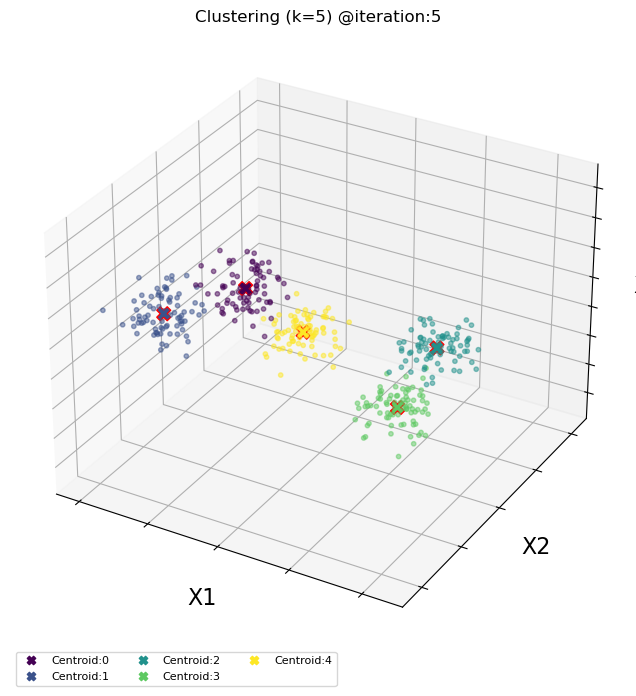

In [15]:
i = len(intermediates) - 1
labels, centroids = intermediates[i]

# Visualize the 3D data
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2],
           c=labels, s=10, alpha = 0.5)
centroid_scatter = ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
                    alpha=1.0, marker='X', edgecolor='r',
                    c=np.arange(len(centroids)), s=100)


ax.set_title(f'Clustering (k={len(centroids)}) @iteration:{i}')
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
ax.set_xlabel('X1'); ax.set_ylabel('X2'); ax.set_zlabel('X3');

plt.legend(handles=centroid_scatter.legend_elements()[0],
           labels=[f'Centroid:{i}' for i in range(len(centroids))],
           loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0))

plt.show()


To visualize the intermediate clustering we take a snapshot at every iteration and then compile them into a GIF animated plot.

In [16]:
import matplotlib.animation as animation

fig = plt.figure(figsize=(12, 8));
ax = fig.add_subplot(111, projection='3d');
def update_plot(i):
    # clear the axis each frame
    ax.clear();
    labels, centroids = intermediates[i]

    ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
    ax.set_xlabel('X1'); ax.set_ylabel('X2'); ax.set_zlabel('X3');
    ax.set_title(f'Clustering (k={len(centroids)}) @iteration:{i}');
    ax.scatter(X[:, 0], X[:, 1], X[:, 2],
               c=labels, s=10, alpha = 0.5);
    centroid_scatter = ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
                alpha=1.0, marker='X', edgecolor='r',
                c=np.arange(len(centroids)), s=100);
    ax.legend(handles=centroid_scatter.legend_elements()[0],
               labels=[f'Centroid:{i}' for i in range(len(centroids))],
               loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0))

ani = animation.FuncAnimation(fig, update_plot,
                              frames=len(intermediates),
                              interval=1000);

# Save it as a GIF file in the current directory and open it.
ani.save(f'kmeans_k{k}.gif', writer='pillow');

plt.clf()

<Figure size 1200x800 with 0 Axes>

#### Questions
1. Change the value for $k$ and observe how this changes the clustering.
2. How could you find the best $k$ without using the knowledge that the number of ground truth clusters is 5?
3. Also change the value of the `random_state` or set it to `None` in the data-generating function. Is the $k$-means algorithm good in finding overlapping clusters?

<a name="section-2"></a>

# Section 2: Hierarchical Clustering ([index](#outline))

One version of hierarchical clustering is the so called *agglomerative clustering*. In agglomerative clustering, we start by considering each of the $N$ examples as a separate cluster. The algorithm then proceeds to merge pairs of clusters starting with the pair that achieves a minimum linkage criterion, and successively repeats the merging of clusters until we end up with one big cluster comprising all the data points. With applying this scheme on our dataset we expect the following clustering trajectory.

![agglomerative](https://raw.githubusercontent.com/barahona-research-group/mfds-resources/main/images/agglomerative_clustering_average_link.gif)



### Pairwise distances

Now let's define a function that returns a Numpy array storing the euclidean distances between every two points in `X`.

In [17]:
def pairwise_distances(points):
    '''
    Args:
        points (np.ndarray): A numpy array of points having the shape (N, p),
          where N is the number of points and p is the number of features.
    Returns:
        (np.ndarray) A numpy array with shape (N, N) such that the element (i, j) is the computed
        distance between i-th point and j-th point in X.
    '''
    N, D = points.shape
    distance = np.empty((N, N))

    # Distance matrix will be symmetric, so maybe avoid redundant computations.
    # ADD LINES BELOW: to populate `distance` with the pairwise distances.
    for i in range(N):
        distance[i, i] = 0
        for j in range(i + 1, N):
            d = np.sqrt(np.sum((points[i, :] - points[j, :])**2))
            distance[i, j] = d
            distance[j, i] = d

    return distance

In [18]:
d = pairwise_distances(X)

You implementation should pass the following simple test case

In [19]:
X_test = np.array([[-3, -4],
                   [0 , 0],
                   [3 , 4]])

npt.assert_allclose(pairwise_distances(X_test),
                    np.array([[0, 5, 10],
                              [5, 0, 5],
                              [10, 5, 0]]))

### Linkage

In the following, we are going to implement the agglomerative algorithm with three different *linkage* criteria, as listed in the notes:

1. Simple Linkage: a simple linkage between two clusters is the minimum distance between any pair of points from the two clusters.
2. Complete Linkage: a complete linkage between two clusters is the maximum distance between any pair of points from the two clusters.
3. Average Linkage: an average linkage between two clusters is the average distance over all pairs of points from the two clusters.

We start by implementing subroutines for computing the three linkage criteria:

In [20]:
def single_linkage(distances, cluster_assignment, i, j):
    """
    This function computes the single linkage value between two clusters.
    Args:
      distances (np.ndarray): A numpy array of pair-wise distances for the given points, shape (N, N).
      cluster_assignment (np.ndarray): A numpy array that assigns a cluster id for every point, shape (N,).
      i (int): the first cluster id.
      j (int): the second cluster id.
    Returns:
      (float): The minimum distance between the two given clusters.
    """
    # Select the point indices of the first cluster.
    points_i = np.argwhere(cluster_assignment == i)
    # Select the point indices of the second cluster.
    points_j = np.argwhere(cluster_assignment == j) 
    # Form a cartesian product between the indices in i and indices in j.
    pairs = np.array([[element_i.item(), element_j.item()]  for element_i in points_i for element_j in points_j])
    # Select the pair distances between the points in the two clusters from the distances matrix.
    pairs_distance = distances[pairs[:, 0], pairs[:, 1]]
    # Return the minimum
    return pairs_distance.min()  

def complete_linkage(distances, cluster_assignment, i, j):
    """
    This function computes the complete linkage value between two clusters.
    Args:
      distances (np.ndarray): A numpy array of pair-wise distances for the given points.
      cluster_assignment (np.ndarray): A 1-D numpy array that assigns a cluster id for every point.
      i (int): the first cluster id.
      j (int): the second cluster id.
    Returns:
      (float): The maximum distance between the two given clusters.
    """
    # Select the point indices of the first cluster.
    points_i = np.argwhere(cluster_assignment == i) 
    # Select the point indices of the second cluster.
    points_j = np.argwhere(cluster_assignment == j) 
    # Form a cartesian product between the indices in i and indices in j.
    pairs = np.array([ [element_i.item(), element_j.item()]  for element_i in points_i for element_j in points_j])
    # Select the pair distances between the points in the two clusters from the distances matrix.
    pairs_distance = distances[pairs[:, 0], pairs[:, 1]]
    # Return the maximum
    return pairs_distance.max()  


def average_linkage(distances, cluster_assignment, i, j):
    """
    This function computes the average linkage value between two clusters.
    Args:
      distances (np.ndarray): A numpy array of pair-wise distances for the given points.
      cluster_assignment (np.ndarray): A 1-D numpy array that assigns a cluster id for every point.
      i (int): the first cluster id.
      j (int): the second cluster id.
    Returns:
      (float): The average distance between the two given clusters.
    """
    # Select the point indices of the first cluster.
    points_i = np.argwhere(cluster_assignment == i) 
    # Select the point indices of the second cluster.
    points_j = np.argwhere(cluster_assignment == j)
    # Form a cartesian product between the indices in i and indices in j.
    pairs = np.array([[element_i.item(), element_j.item()]  for element_i in points_i for element_j in points_j])
    # Select the pair distances between the points in the two clusters from the distances matrix.
    pairs_distance = distances[pairs[:, 0], pairs[:, 1]]
    # Return the average
    return pairs_distance.mean()  

We are now ready to implement the agglomerative hierarchical clustering algorithm.

In [21]:
def hierarchical_clustering(points, distances, linkage):
    """
    The agglomerative hierarchical clustering algorithm start with every point as a single
    cluster and each iteration merges two clusters into one. We may wish to store all the
    intermediate clustering results with respect to the number of clusters left.

    Args:
     points: A numpy array of points having the shape (N, D),
          where N is the number of points and D is the number of features.
     distances: A numpy array with shape (N, N) such that the element (i, j) is the computed
        distance between i-th point and j-th point in X.
     linkage: A linkage function from the above to call to compute the linkage values between two clusters.

    Returns:
     (np.ndarray):  A numpy array of shape (N, N) of which each row stores the clustering assignment at each level.
     The first row, i.e. a[0, :], represents the highest level of clustering where all columns have the same index value.
     The second row, i.e. a[1, :], represents all the points assigned into two cluster indices.
     The last row, i.e. a[N - 1, :], represents the points assigned into N - 1 cluster indices.
    """
    N, D = points.shape
    assignments = np.zeros((N, N))

    # Begin with every point in its own cluster
    current_assignment = np.arange(N)   

    # The id to be assigned for the next merged cluster
    next_cluster_id = N

    # Begin from level (N - 1) to level 1
    for level in tqdm(range(N - 1, 0, -1)):

        cluster_ids = np.unique(current_assignment)

        min_d = np.inf

        # Initialize the cluster ids to be merged in this iteration.
        cluster_a, cluster_b = (-1, -1)

        # Now find the two clusters that have the minimum distance in between.
        for i in range(cluster_ids.size):  
            for j in range(i + 1, cluster_ids.size):   
                cluster_i = cluster_ids[i]  
                cluster_j = cluster_ids[j]  
                d = linkage(distances, current_assignment, cluster_i, cluster_j)  
                if d < min_d: 
                    min_d = d   
                    cluster_a, cluster_b = (cluster_i, cluster_j)  


        # Merge the two clusters
        current_assignment[(current_assignment == cluster_a) | (current_assignment == cluster_b)] = next_cluster_id 

        next_cluster_id += 1
        # Store the current cluster assignment into the assignments array.
        assignments[level, :] = current_assignment

    return assignments

We can now apply hierarchical clustering to our synthetic data.

In [22]:
a = hierarchical_clustering(X, d, average_linkage)

  0%|          | 0/399 [00:00<?, ?it/s]

Similarly to $k$-means clustering it is not easy to choose the best level in the dendrogram of hierarchical clustering. As we know that our data has 5 ground-truth clusters, we visualise level 5 below.

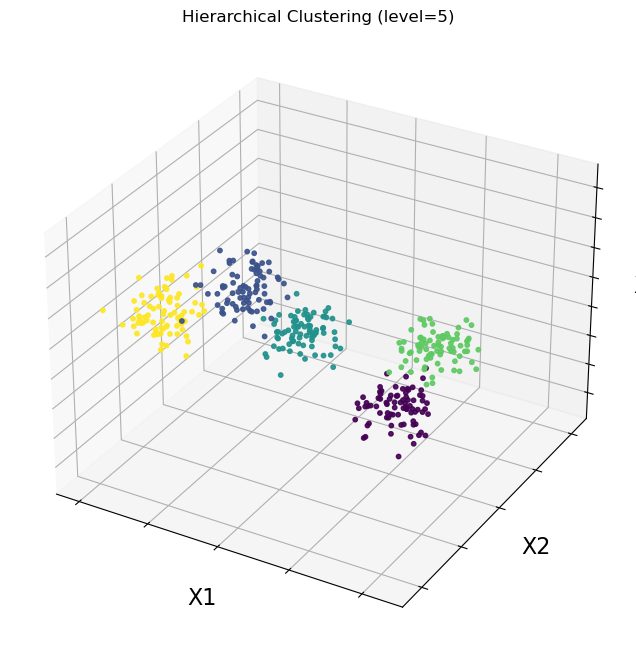

In [23]:
level = 5

level_vals = list(sorted(set(a[level])))
simple_labels = [level_vals.index(v) for v in a[level]]

# Visualize the 3D data
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2],
           c=simple_labels, s=10, alpha = 0.9)


ax.set_title(f'Hierarchical Clustering (level={level})')
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
ax.set_xlabel('X1'); ax.set_ylabel('X2'); ax.set_zlabel('X3');

plt.show()

To visualise the clustering at all levels we again produce an animation.

In [24]:
import matplotlib.animation as animation
from matplotlib import cm
cmap_colors = cm.tab20.colors

fig = plt.figure(figsize=(12, 8));
ax = fig.add_subplot(111, projection='3d');

# Select levels to show.
levels = list(range(10)) + list(range(10, 100, 10))
levels = [l for l in levels if l < len(a)]
def update_plot(i):
    # clear the axis each frame
    ax.clear();
    level = levels[len(levels) - i - 1]
    level_clusters = a[level]

    colors = np.array([cmap_colors[int(l) % 20] for l in level_clusters])

    ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
    ax.set_xlabel('X1'); ax.set_ylabel('X2'); ax.set_zlabel('X3');
    ax.set_title(f'Clustering @level:{level}');

    still_mask = (a[level] == a[min(level + 1, len(a) - 1)])
    ax.scatter(X[:, 0], X[:, 1], X[:, 2],
               c=colors, s=50, alpha = 0.7,
               linewidth=np.where(still_mask, 0, 2),
               edgecolor=np.where(still_mask, 'none', 'r'))


ani = animation.FuncAnimation(fig, update_plot,
                              frames=len(levels),
                              interval=1000);

# Save it as a GIF file in the current directory and open it.
ani.save(f'agglomerative_clustering_average_link.gif', writer='pillow');

plt.clf()

<Figure size 1200x800 with 0 Axes>

#### Questions
1. What are the inherent advantages of hierarchical clustering over $k$-means?
2. Try out different linkage methods. Can you observe any differences? If so, where do these differences come from?
3. Can you replicate your results for both algorithms with sklearn?
4. Do both algorithms perform well on a [dataset of handwritten digits](https://scikit-learn.org/stable/datasets/toy_dataset.html#digits-dataset)?